<hr style="border:2px solid gray"> </hr>

# Traveling Salesman Problem

### Genetic Algorithm 
<hr style="border:2px solid gray"> </hr>

# Step 0. Importing packages and Global Settings

---------------------------------------------------------------
## (Optional) For Colab

---------------------------------------------------------------

In [1]:
# package list
import numpy as np
import sys
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import time

# Global Variables
# GA
POOL_SIZE = 20
TOURNAMENT_SIZE = 5
MAX_ITERATION = 10000

# SA
MAX_EVALUATION = 100
SUB_ITERATIONS = 50
TEMPERATURE = 100
COOLING_RATIO = 0.5
TEMP_LIMIT = 1

np.random.seed(0)
# Plot Settings
PLOT_MODE = False #Draw Route
AVERAGE_COST_PRINT = True
plt.ion()

# First City Index
FIRST_IDX = 0

averages = []

In [2]:
file_path = 'data1.txt'

# Step 1. Data Loading

In [3]:
def fileloader():
    #     Data Format
    #     ---------------------------------------------------------
    #     NAME : pia3056
    #     COMMENT : Bonn VLSI data set with 3056 points
    #     COMMENT : Uni Bonn, Research Institute for Discrete Math
    #     COMMENT : Contributed by Andre Rohe
    #     TYPE : TSP
    #     DIMENSION : 3056 -----------------------------|
    #     EDGE_WEIGHT_TYPE : EUC_2D                     |
    #     NODE_COORD_SECTION                            |
    #     1 0 11 (2 dimentional coordinate of city)     |
    #     2 0 115                                       |
    #     ...                                           |
    #     ...(Total 3056 nodes)<------------------------|
    #     EOF
    #     ---------------------------------------------------------
    with open(file_path, "r") as file:
        file_str = file.readlines()

    # Get the coordinates of cities
    coord_str = file_str[8:-1]  # first city string to last city string (EOF 전까지)
    coord_list = np.zeros((len(coord_str), 2))
    for idx, item in enumerate(coord_str):
        items = item.split()
        coord_list[idx, 0], coord_list[idx, 1] = int(items[1]), int(items[2])

    return coord_list

# Step 2. Initialization

In [4]:
def initialize_greedy(coord_list, first_idx):
    cnt_cities = len(coord_list)
    # Initialize path and insert first city index to the first and last elements
    path = np.zeros(cnt_cities + 1, dtype=np.int32)
    path[0], path[-1] = first_idx, first_idx

    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)
    
    cities_tovisit = np.ones((cnt_cities), dtype=np.bool_)
    cities_tovisit[first_idx] = False

    # Iteratively Connect nearest cities
    for i in range(1, cnt_cities):
        start_idx = path[i - 1]
        distance_from_start = path_map[start_idx, :]
        nearest_list = np.argsort(distance_from_start)
        for idx in range(len(nearest_list)):
            # check the nearest city is visited
            if cities_tovisit[nearest_list[idx]]:
                nearest_city = nearest_list[idx]
                break
        cities_tovisit[nearest_city] = False
        path[i] = nearest_city

    return path_map, path

def initialize_random(coord_list, first_idx):
    cnt_cities = len(coord_list)
    path = np.zeros(cnt_cities + 1, dtype=np.int32)

    path[0], path[-1] = first_idx, first_idx
    # Euclidean distance map between cities
    path_map = euclidean_distances(coord_list, coord_list)

    # city indices without first city index
    cities_tovisit = np.delete(np.arange(cnt_cities), first_idx)
    cities_random = np.random.permutation(cities_tovisit)
    path[1:-1] = cities_random

    return path_map, path

def path_cost(path_map, path):
    # The array of cost between cities in the path
    cnt_cities = path_map.shape[0]
    cost_arr = np.zeros(cnt_cities)
    for i in range(cnt_cities):
        cost_arr[i] = path_map[path[i], path[i+1]]

    return cost_arr

# Step 3. Searching a path

## Algorithm 4. Genetic Algorithm 

In [5]:
def two_opt_swap(path_map, path, iterations, coord_list):
    cnt_cities = path_map.shape[0]
    # Save the best path

    cost_arr = path_cost(path_map, path)
    best_path = path.copy()
    best_cost = cost_arr.sum()
    
    for i in range(iterations):
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)

        # Compare to the best path
        curr_cost = cost_arr.sum()
        if curr_cost < best_cost:
            best_path = curr_path
            best_cost = curr_cost
    
    temperature = TEMPERATURE
    while temperature > TEMP_LIMIT:
        curr_path = best_path.copy()
        # Select two indices of flip points
        sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities + 1), 2))

        # Path Flip and update cost array
        curr_path[sel_idx[0]:sel_idx[1]] = np.flip(curr_path[sel_idx[0]: sel_idx[1]])
        cost_arr = path_cost(path_map, curr_path)
        curr_cost = cost_arr.sum()

        if curr_cost <= best_cost:
            best_path, best_cost = curr_path, curr_cost
        else:
            prob = 1 / np.exp((curr_cost - best_cost) / float(temperature))
            if prob > np.random.rand(1):
                best_path, best_cost = curr_path, curr_cost
        temperature = temperature * COOLING_RATIO 
    return best_path, best_cost

In [6]:
def sa(path_map, path, coord_list):
    best_path, best_cost = path.copy() , path_cost(path_map, path).sum()

    for i in range(MAX_EVALUATION):
        curr_path = best_path.copy()
        new_path, new_cost = two_opt_swap(path_map, curr_path, SUB_ITERATIONS, coord_list)

        if new_cost < best_cost:
            best_path, best_cost = new_path, new_cost
            
    return best_path, best_cost

In [7]:
def initialization(coord_list):
    cnt_cities = len(coord_list)
    path_pool = np.zeros((POOL_SIZE, cnt_cities + 1), dtype=np.int32)
    pool_cost = np.zeros(POOL_SIZE)
    
    path_map, path_pool[0, :] = initialize_greedy(coord_list, FIRST_IDX)
    pool_cost[0] = path_cost(path_map, path_pool[0, :]).sum()

#     print('Path {} is initialized'.format(0))

    for i in range(1, POOL_SIZE):
        _, path_pool[i, :] = initialize_random(coord_list, FIRST_IDX)
        path_pool[i, :], pool_cost[i] = sa(path_map, path_pool[i, :], coord_list) 
        #random 하게 initialize, sa로 다듬은 후  삽입
#         print('Path {} is initialized'.format(i))
    
    return path_pool, pool_cost, path_map

In [8]:
def simple_best_selection(pool_cost, TOURNAMENT_SIZE, sel_size = 2):
    sort_idx = np.argsort(pool_cost)
    best_idx = sort_idx[0:sel_size]
    return best_idx

In [9]:
def selection(pool_cost, TOURNAMENT_SIZE, sel_size=2):
    # tournament selection
    sel_idx = np.random.choice(POOL_SIZE, TOURNAMENT_SIZE, replace=False)
    sel_cost = pool_cost[sel_idx]
    best_idx = sel_idx[np.argsort(sel_cost)][:sel_size]
    return best_idx

In [10]:
# pmx crossover
def crossover(path1, path2, path_map):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Initialize child path
    child_path = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path[0], child_path[-1] = -1, -1
    # Copy the path between crossover points
    child_path[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    # Copy the rest of the path from path2
    path2_idx = np.where(np.isin(path2, child_path) == False)[0]
    child_path[np.where(child_path == 0)[0]] = path2[path2_idx]
    child_path[0], child_path[-1] = FIRST_IDX, FIRST_IDX

    return child_path


In [11]:
# pmx crossover
def crossover_ver1(path1, path2, path_map):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Initialize child path
    child_path = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path2 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path[0], child_path[-1] = -1, -1
    child_path2[0], child_path2[-1] = -1, -1
    
    # Copy the path between crossover points
    child_path[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    child_path2[sel_idx[0]:sel_idx[1]] = path2[sel_idx[0]:sel_idx[1]]
    
    # Copy the rest of the path from path2
    path2_idx = np.where(np.isin(path2, child_path) == False)[0]
    path1_idx = np.where(np.isin(path1, child_path2) == False)[0]
    child_path[np.where(child_path == 0)[0]] = path2[path2_idx]
    child_path2[np.where(child_path2 == 0)[0]] = path1[path1_idx]
    child_path[0], child_path[-1] = FIRST_IDX, FIRST_IDX
    child_path2[0], child_path2[-1] = FIRST_IDX, FIRST_IDX
    
    child_cost = path_cost(path_map, child_path).sum()
    child_cost2 = path_cost(path_map, child_path2).sum()
    
    if child_cost < child_cost2:
        return child_path
    else:
        return child_path2

    
    return child_path

In [12]:
# Create two child using OX crossover. 
# Return both of them.
def crossover_ox_r2(path1, path2):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Initialize child path
    child_path1 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path2 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path1[0], child_path1[-1], child_path2[-1], child_path2[0] = -1, -1, -1, -1
    
    #Copy path between crossover points
    child_path1[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    child_path2[sel_idx[0]:sel_idx[1]] = path2[sel_idx[0]:sel_idx[1]]
#     print(f'crossover point : {sel_idx[0]}, {sel_idx[1]}')
    
    #Copy rest of the part 
    path1_i, path2_i = 1, 1
    for i in range(sel_idx[1], cnt_cities):
        while path2[path2_i] in child_path1[sel_idx[0]:sel_idx[1]]:
            path2_i += 1
        while path1[path1_i] in child_path2[sel_idx[0]:sel_idx[1]]:
            path1_i += 1
        child_path1[i] = path2[path2_i]
        child_path2[i] = path1[path1_i]
        path1_i += 1
        path2_i += 1
        
#     print(f'path1_i : {path1_i}, path2_i : {path2_i}')
#     print(f'child path : {child_path1}, {child_path2}')

    for i in range(1, sel_idx[0]):
        while path2[path2_i] in child_path1[sel_idx[0]:sel_idx[1]]:
            path2_i += 1
        while path1[path1_i] in child_path2[sel_idx[0]:sel_idx[1]]:
            path1_i += 1
        child_path1[i] = path2[path2_i]
        child_path2[i] = path1[path1_i]
        path1_i += 1
        path2_i += 1
    
    child_path1[0], child_path1[-1], child_path2[0], child_path2[-1] = FIRST_IDX, FIRST_IDX, FIRST_IDX, FIRST_IDX
    return child_path1, child_path2

In [13]:
# ox crossover
# Create two child using OX crossover. 
# Compare them, return child with better cost.
def crossover_ox(path1, path2, path_map):
    cnt_cities = len(path1) - 1
    # Select two indices of crossover points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Initialize child path
    child_path1 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path2 = np.zeros(cnt_cities + 1, dtype=np.int32)
    child_path1[0], child_path1[-1], child_path2[-1], child_path2[0] = -1, -1, -1, -1
    
    #Copy path between crossover points
    child_path1[sel_idx[0]:sel_idx[1]] = path1[sel_idx[0]:sel_idx[1]]
    child_path2[sel_idx[0]:sel_idx[1]] = path2[sel_idx[0]:sel_idx[1]]
#     print(f'crossover point : {sel_idx[0]}, {sel_idx[1]}')
    
    #Copy rest of the part 
    path1_i, path2_i = 1, 1
    for i in range(sel_idx[1], cnt_cities):
        while path2[path2_i] in child_path1[sel_idx[0]:sel_idx[1]]:
            path2_i += 1
        while path1[path1_i] in child_path2[sel_idx[0]:sel_idx[1]]:
            path1_i += 1
        child_path1[i] = path2[path2_i]
        child_path2[i] = path1[path1_i]
        path1_i += 1
        path2_i += 1
        
#     print(f'path1_i : {path1_i}, path2_i : {path2_i}')
#     print(f'child path : {child_path1}, {child_path2}')

    for i in range(1, sel_idx[0]):
        while path2[path2_i] in child_path1[sel_idx[0]:sel_idx[1]]:
            path2_i += 1
        while path1[path1_i] in child_path2[sel_idx[0]:sel_idx[1]]:
            path1_i += 1
        child_path1[i] = path2[path2_i]
        child_path2[i] = path1[path1_i]
        path1_i += 1
        path2_i += 1
    
    child_path1[0], child_path1[-1], child_path2[0], child_path2[-1] = FIRST_IDX, FIRST_IDX, FIRST_IDX, FIRST_IDX
#     print(f'original path: {path1} \n {path2}')
#     print(f'child path : {child_path1}, {child_path2}')

    child1_cost = path_cost(path_map, child_path1).sum()
    child2_cost = path_cost(path_map, child_path2).sum()
    
    if child1_cost < child2_cost:
        return child_path1
    else:
        return child_path2

In [14]:
# swap mutation
def mutation(path):
    cnt_cities = len(path)
    child_path = path.copy()
    # Select two indices of mutation points
    sel_idx = np.sort(np.random.choice(np.arange(1, cnt_cities), 2))
    # Swap the path between mutation points
    child_path[sel_idx[0]:sel_idx[1]] = np.flip(child_path[sel_idx[0]:sel_idx[1]])

    return child_path 


In [15]:
#insert mutation
def insert_mutation(path):
    cnt_cities = len(path)
    child_path = path.copy()
    sel_idx = np.random.choice(np.arange(1, cnt_cities - 1), 2, replace = False) #sel_idx[0]: selected city index sel_idx[1] : where to insert
    
    moving_city = child_path[sel_idx[0]]
    child_path = np.delete(child_path, sel_idx[0])
    child_path = np.insert(child_path, sel_idx[1], moving_city)

    return child_path

In [16]:
#shuffle mutation
def shuffle_mutation(path):
    cnt_cities = len(path)
    child_path = path.copy()
    sel_idx = np.random.choice(np.arange(1, cnt_cities), 2) 
    np.random.shuffle(child_path[sel_idx[0]: sel_idx[1]])
    return child_path

In [17]:
# genetic algorithm
def ga(coord_list, crossover_func):
    best_cost = np.Inf
#     print('Start Genetic Algorithm')
#     print('Initialize the population')
    path_pool, pool_cost, path_map = initialization(coord_list)
    
#     print('Start the evolution')
    for i in range(MAX_ITERATION):
#         if (i+1) % 1000 == 0:
#             print('Iteration {}'.format(i + 1))
        # selection
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE)
        #print('selection result : ', sel_idx)
        
        # crossover
        child_crx = crossover_func(path_pool[sel_idx[0]], path_pool[sel_idx[1]], path_map)
        cost_crx = path_cost(path_map, child_crx).sum()
        
        # mutation
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE, sel_size=1)
        child_mut = mutation(path_pool[sel_idx[0]])
        cost_mut = path_cost(path_map, child_mut).sum()
        # replace
        sort_idx = np.argsort(pool_cost)
        
        #기존 pool에서 가장 성능이 안좋은 두 개에 덮어쓰기 
        path_pool[sort_idx[-1]], pool_cost[sort_idx[-1]] = child_crx, cost_crx 
        path_pool[sort_idx[-2]], pool_cost[sort_idx[-2]] = child_mut, cost_mut 
        
        #extra code when using crossover_ox_r2
#         path_pool[sort_idx[-3]], pool_cost[sort_idx[-3]] = child_crx2, path_cost(path_map, child_crx2).sum()

        #현재 풀에서 가장 짧은 경로
        cur_idx = np.argmin(pool_cost)
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]
        
        if AVERAGE_COST_PRINT:
            average_cost = sum(pool_cost)/len(pool_cost)
            averages.append(average_cost)
        
        if best_cost > cur_cost:
            best_cost = cur_cost
            if PLOT_MODE:
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[cur_path, :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()
            

    best_idx = np.argmin(pool_cost)
    return path_pool[best_idx], pool_cost[best_idx]

In [18]:
# genetic algorithm
def my_ga(coord_list):
    best_cost = np.Inf
    path_pool, pool_cost, path_map = initialization(coord_list)
    
#     print('Start the evolution')
    for i in range(MAX_ITERATION):
        sel_idx = selection(pool_cost, TOURNAMENT_SIZE)
        
        # crossover
        child_crx = crossover_ox(path_pool[sel_idx[0]], path_pool[sel_idx[1]], path_map)
        cost_crx = path_cost(path_map, child_crx).sum()
        
        # mutation
        sel_idx =  simple_best_selection(pool_cost, 10, sel_size=1)
        child_mut = mutation(path_pool[sel_idx[0]])
        cost_mut = path_cost(path_map, child_mut).sum()
        # replace
        sort_idx = np.argsort(pool_cost)
        
        #기존 pool에서 가장 성능이 안좋은 두 개에 덮어쓰기 
        path_pool[sort_idx[-1]], pool_cost[sort_idx[-1]] = child_crx, cost_crx 
        path_pool[sort_idx[-2]], pool_cost[sort_idx[-2]] = child_mut, cost_mut 

        #현재 풀에서 가장 짧은 경로
        cur_idx = np.argmin(pool_cost)
        cur_path = path_pool[cur_idx]
        cur_cost = pool_cost[cur_idx]
        
        if AVERAGE_COST_PRINT:
            average_cost = sum(pool_cost)/len(pool_cost)
            averages.append(average_cost)
        
        if best_cost > cur_cost:
            best_cost = cur_cost
            if PLOT_MODE:
                plt.close()
                figure, ax = plt.subplots()
                plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
                plt.title('City Route: Iteration {}'.format(i + 1))
                coord_path = coord_list
                coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
                coord_path[:, :] = coord_path[cur_path, :]
                lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
                figure.canvas.draw()
                figure.canvas.flush_events()
                plt.show()
            

    best_idx = np.argmin(pool_cost)
    return path_pool[best_idx], pool_cost[best_idx]

# Main

Execution Time: 13.587107419967651
Path: [0, 11, 4, 12, 17, 24, 16, 15, 14, 13, 5, 6, 7, 1, 2, 8, 9, 3, 10, 23, 40, 41, 42, 43, 60, 59, 58, 57, 56, 50, 51, 49, 55, 62, 66, 70, 69, 65, 61, 64, 68, 81, 86, 87, 85, 84, 83, 82, 78, 75, 79, 71, 72, 89, 90, 94, 95, 96, 103, 102, 110, 109, 91, 93, 98, 101, 100, 99, 104, 105, 106, 112, 107, 108, 114, 118, 115, 119, 116, 121, 128, 127, 126, 130, 125, 124, 123, 113, 117, 120, 129, 122, 111, 97, 92, 88, 80, 77, 76, 74, 67, 63, 73, 52, 44, 45, 53, 54, 48, 47, 46, 26, 25, 18, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 22, 21, 20, 19, 0]
Cost: 627.8930126009213


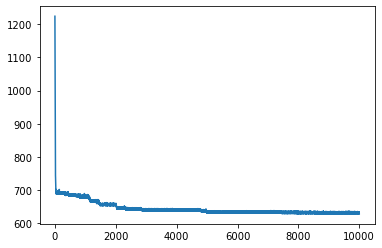

In [19]:
# Step 1
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

best_path, best_cost = ga(coord_list, crossover)

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(best_path.tolist()))
print('Cost: ' + str(best_cost))
plt.plot(averages)

<h1>ORIGINAL 함수 n 회 반복 테스트<h1>

Execution Time: 129.01861786842346
Best of Best Path: [0, 5, 11, 4, 12, 17, 13, 14, 15, 16, 24, 25, 26, 18, 19, 20, 33, 32, 31, 30, 29, 28, 27, 53, 45, 44, 52, 73, 88, 76, 67, 63, 74, 77, 80, 81, 86, 87, 91, 93, 98, 101, 105, 104, 99, 100, 92, 97, 111, 113, 117, 120, 122, 129, 130, 128, 127, 126, 125, 124, 123, 112, 106, 107, 108, 114, 118, 115, 119, 121, 116, 109, 110, 102, 103, 96, 95, 94, 89, 90, 72, 71, 79, 85, 84, 83, 82, 78, 75, 70, 66, 62, 65, 69, 68, 64, 61, 54, 46, 47, 48, 49, 50, 51, 55, 56, 57, 58, 59, 60, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 21, 22, 23, 10, 3, 9, 8, 2, 1, 7, 6, 0]
Best of Best Cost: 599.8110020293736
Average :  617.1702847578923


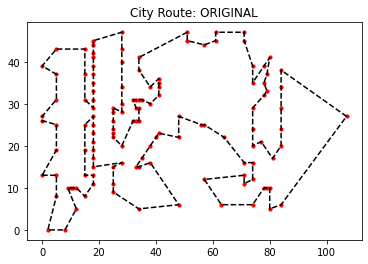

In [20]:
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

original_bob_cost = np.inf
original_bob_path = []
original_sum = 0

TEST_ITERATION = 10

for i in range(TEST_ITERATION):
    best_path, best_cost = ga(coord_list, crossover)
    original_sum += best_cost
    if best_cost < original_bob_cost:
        original_bob_cost = best_cost
        original_bob_path = best_path

print('Execution Time: ' + str(time.time() - start_time))
print('Best of Best Path: ' + str(original_bob_path.tolist()))
print('Best of Best Cost: ' + str(original_bob_cost))
print('Average : ', original_sum / TEST_ITERATION)

plt.close()
figure, ax = plt.subplots()
plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
plt.title('City Route: ORIGINAL')
coord_path = coord_list
coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
coord_path[:, :] = coord_path[original_bob_path, :]
lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
figure.canvas.draw()
figure.canvas.flush_events()
plt.show()

<h1>개선 함수 n 회 반복 테스트<h1>

Execution Time: 231.48696279525757
Path: [0, 11, 4, 12, 17, 24, 16, 15, 14, 13, 5, 19, 20, 21, 22, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 18, 25, 26, 44, 52, 73, 88, 92, 86, 87, 91, 93, 98, 106, 107, 108, 112, 105, 101, 100, 99, 104, 97, 111, 129, 122, 113, 117, 120, 123, 124, 125, 130, 126, 127, 128, 121, 116, 119, 115, 118, 114, 109, 110, 102, 103, 96, 95, 94, 89, 90, 72, 71, 79, 85, 84, 83, 82, 78, 75, 70, 66, 62, 65, 69, 61, 64, 68, 81, 80, 77, 74, 76, 67, 63, 45, 53, 54, 46, 47, 48, 49, 50, 51, 55, 56, 57, 58, 59, 60, 43, 42, 23, 10, 3, 9, 8, 2, 1, 7, 6, 0]
Cost: 606.778150197484
Average:  618.9008650754074


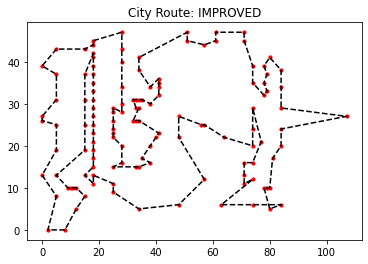

In [800]:
try:
    coord_list = fileloader()
except Exception as e:
    print('예외 발생', e)
    sys.exit()

start_time = time.time()

my_bob_cost = np.inf
my_sum = 0

TEST_ITERATION = 10

for i in range(TEST_ITERATION):
    best_path, best_cost = my_ga(coord_list)
    my_sum += best_cost
    if best_cost < my_bob_cost:
        my_bob_cost = best_cost
        my_bob_path = best_path

print('Execution Time: ' + str(time.time() - start_time))
print('Path: ' + str(my_bob_path.tolist()))
print('Cost: ' + str(my_bob_cost))
print('Average: ', my_sum / TEST_ITERATION)

plt.close()
figure, ax = plt.subplots()
plt.scatter(coord_list[:, 0], coord_list[:, 1], c='red', s=10)
plt.title('City Route: IMPROVED')
coord_path = coord_list
coord_path = np.append(coord_path, coord_path[FIRST_IDX, :].reshape(1, 2), axis=0)
coord_path[:, :] = coord_path[my_bob_path, :]
lines, = ax.plot(coord_path[:, 0], coord_path[:, 1], 'k--')
figure.canvas.draw()
figure.canvas.flush_events()
plt.show()

# 